<a href="https://colab.research.google.com/github/ShwetaBaranwal/Medium-Posts/blob/master/variance_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import warnings
warnings.filterwarnings("ignore")

### Stratification

In [2]:
def generate_stratified_data(size, treatment_effect):
  df = pd.DataFrame()
  df_1 = pd.DataFrame({'strata': 1, 'y': np.random.normal(10, 1, size=size)})
  df_2 = pd.DataFrame({'strata': 2, 'y': np.random.normal(15, 2, size=size)})
  df_3 = pd.DataFrame({'strata': 3, 'y': np.random.normal(20, 3, size=size)})
  df_4 = pd.DataFrame({'strata': 4, 'y': np.random.normal(25, 4, size=size)})
  df = df_1.append(df_2).append(df_3).append(df_4)
  df['group'] = np.random.randint(0,2,df.shape[0])
  df.loc[df["group"] == 1, 'y'] += treatment_effect
  return df

In [3]:
def meandiff(df):
  return df[df['group']==1]['y'].mean() - df[df['group']==0]['y'].mean()


In [4]:
def stratify_meandiff(df):
  s = 0
  N = df.shape[0]
  for i in range(1,5):
    df_k = df[df['strata']==i]
    w = df_k.shape[0]/N
    yt = df_k[df_k['group']==1]['y']
    yc = df_k[df_k['group']==0]['y']
    s += w*(yt.mean() - yc.mean())
  return s

In [5]:
sim_meandiff = []
sim_stratify_meandiff = []

for i in range(400):
  df = generate_stratified_data(50, 1)
  sim_meandiff.append(meandiff(df))
  sim_stratify_meandiff.append(stratify_meandiff(df))


In [6]:
np.mean(sim_stratify_meandiff), np.mean(sim_meandiff)

(0.9895628668470193, 0.9866178223107798)

In [7]:
np.var(sim_stratify_meandiff), np.var(sim_meandiff)

(0.15153116677701706, 0.8220925979039723)

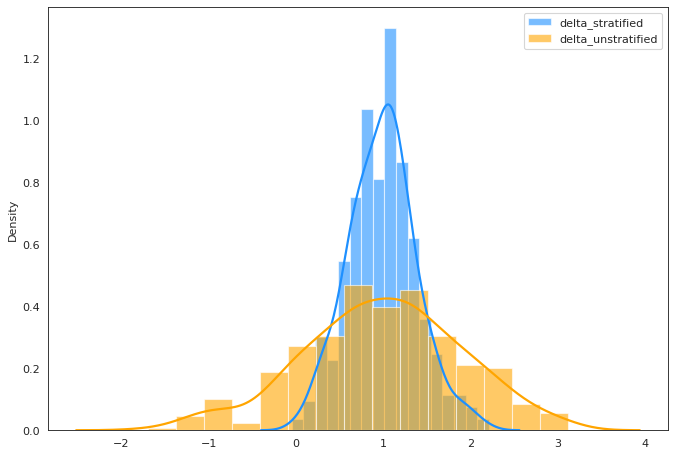

In [8]:
# Plot
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(sim_stratify_meandiff, color="dodgerblue", label="delta_stratified", **kwargs)
sns.distplot(sim_meandiff, color="orange", label="delta_unstratified", **kwargs)
plt.legend();


### CUPED

In [9]:
def generate_data(treatment_effect, size):
  mu = np.array([5.0, 0.0])

  # The desired covariance matrix.
  r = np.array([
          [ 3.40, 2.75],
          [ 2.75, 1.50]
      ])

  # Generate the random samples.
  rng = np.random.default_rng()
  data = rng.multivariate_normal(mu, r, size=size)
  df = pd.DataFrame()
  df['y'] = data[:,0]
  df['X'] = data[:,1]
  df['group'] = np.random.randint(0,2, size = size)
  df.loc[df["group"] == 1, 'y'] += treatment_effect
  return df

In [10]:
d = generate_data(2, 100)
d.head()

,y,X,group
0,4.315428,-1.361751,0
1,7.365380,-0.746655,1
2,5.557211,-0.046588,0
3,5.595958,-0.177928,0
4,3.912710,-2.493686,1


In [11]:
def meandiff(df):
  return df[df['group']==1]['y'].mean() - df[df['group']==0]['y'].mean()


In [12]:
meandiff(d)

1.880959720341898

In [13]:
def adjusted_meandiff(df):
  cv = np.cov(df['X'], df['y'])
  theta = df.cov()['X']['y'] / df.cov()['X']['X']
  mean_X = np.mean(df['X'])

  df_trt = df[df['group']==1]
  df_cntrl = df[df['group']==0]

  adjusted_trt = df_trt['y'] - (df_trt['X'] - mean_X) * theta 
  adjusted_cntrl = df_cntrl['y'] - (df_cntrl['X'] - mean_X) * theta 

  adjusted_meandiff = adjusted_trt.mean() - adjusted_cntrl.mean()

  # print(1-np.square(d.corr()['X']['y']), np.var(np.concatenate([adjusted_trt,adjusted_cntrl]))/np.var(df['y']))
  return adjusted_meandiff


In [14]:
adjusted_meandiff(d)

1.982330583238098

In [15]:
sim_meandiff = []
sim_adjusted_meandiff = []

for i in range(400):
  df = generate_data(1, 50)
  sim_meandiff.append(meandiff(df))
  sim_adjusted_meandiff.append(adjusted_meandiff(df))


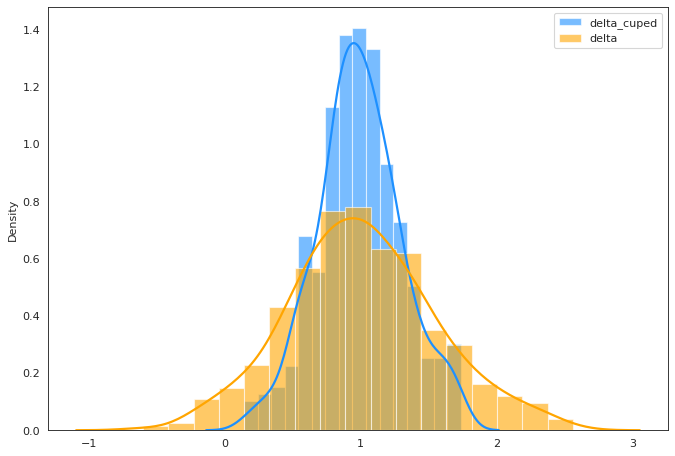

In [16]:
# Plot
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(sim_adjusted_meandiff, color="dodgerblue", label="delta_cuped", **kwargs)
sns.distplot(sim_meandiff, color="orange", label="delta", **kwargs)
plt.legend();
